# Repetition probability visual

Analysis for the visual experiment, looks at repetition probabilities as a function of psychosis-proneness, as well as corrected partial correlations that check for performance levels

(c) Anna-Lena Eckert

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys, os, glob
import csv
import pingouin as pg

from scipy.stats import ttest_rel
from pathlib import Path

# settings for more convenient df inspection
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [4]:
# change into folder that contains data. 
path = os.getcwd()
p = Path(path).parents[1]
file_path = str(p) + '\\Data\\Exp2_visual\\'
os.chdir(file_path)

df = pd.read_csv('exp2_model1_visual.csv')
# drop random unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

# exclude subject who did not meet performance criterion
df = df.drop(df[df.sbj_id == 'ANI05H'].index)
print(len(list(df['sbj_id'].unique())))

41


In [6]:
# create repetition column, if == 0: current response is NOT a repetition, elif == 1: IS repetition
df['repeat'] = np.nan

for index, row in df.iterrows(): 
    if row['response'] == row['resp_1']: 
        rep = 1
    elif row['response'] != row['resp_1']: 
        rep = 0
        
    df.at[index, 'repeat'] = rep

In [7]:
subjects = list(df['sbj_id'].unique())

# initialize result frame
df_rep = pd.DataFrame(columns=['sbj_id', 'rep_prob', 'rep_prob_rep', 'rep_prob_neut', 'PPS'])

for sbj_id in subjects:
    # get overall repetition probability across blocks
    df_sbj = df[df['sbj_id']==sbj_id]
    rep_mean = df_sbj['repeat'].mean()
    pps = df_sbj['PPS'].mean()
    
    # get repetition probability in repetitive blocks careful: coding is reversed in Exp. 1
    rep_rep_mean = df_sbj[df_sbj['block_type']==1]['repeat'].mean()
    
    # get repetition probability in neutral blocks
    rep_neut_mean = df_sbj[df_sbj['block_type']==0]['repeat'].mean()
    
    # put it in result df
    case = {'sbj_id':sbj_id,'rep_prob':rep_mean,'rep_prob_rep':rep_rep_mean,'rep_prob_neut':rep_neut_mean,'PPS':pps}
    df_rep = df_rep.append(case, ignore_index = True)

In [8]:
# correlate mean repetition probability and PPS in repetitive blocks
corr_pps_rep = np.corrcoef(df_rep['PPS'], df_rep['rep_prob_rep'])
corr_pps_rep = corr_pps_rep[0][1]

# correlate mean repetition prob and PPS in neutral blocks
corr_pps_neut = np.corrcoef(df_rep['PPS'], df_rep['rep_prob_neut'])
corr_pps_neut = corr_pps_neut[0][1]

# correlate overall mean repetition prob and PPS
corr_pps = np.corrcoef(df_rep['PPS'], df_rep['rep_prob'])
corr_pps = corr_pps[0][1]

In [11]:
subjects = list(df_rep.index)
df_rep['performance'] = np.nan
#df_rep.set_index('sbj_id', inplace=True)

for sbj in subjects[0:42]: 
    df_sbj = df[df['sbj_id']==sbj]
    res = df_sbj.groupby(['target', 'response']).size().reset_index(name="freq")
    total_trials = res['freq'].sum()
    count_corr = res[(res['target']==0) == (res['response']==0)]['freq'].sum()
    perc_correct = (count_corr/ total_trials)*100
    
    df_rep.at[sbj, 'performance'] = perc_correct   

<ipython-input-11-1de79ab3c21b>:10: RuntimeWarning: invalid value encountered in longlong_scalars
  perc_correct = (count_corr/ total_trials)*100


In [12]:
print('Mean performance: %.3f percent' % df_rep['performance'].mean())
print('Mean performance std: %.3f' % df_rep['performance'].std())

Mean performance: 72.096 percent
Mean performance std: 4.292


In [13]:
min_perform = df_rep['performance'].min()
max_perform = df_rep['performance'].max()

display(df_rep[df_rep['performance']==min_perform])
display(df_rep[df_rep['performance']==max_perform])

,rep_prob,rep_prob_rep,rep_prob_neut,PPS,performance
sbj_id,,,,,
FES01B,0.576316,0.489474,0.663158,-1.121052,64.210526


,rep_prob,rep_prob_rep,rep_prob_neut,PPS,performance
sbj_id,,,,,
GUY14C,0.555263,0.528947,0.581579,-1.072565,79.605263


In [14]:
# partial correlation between PPS and repetition probability but controlled for performance, using pingouin package 
# create partial correlation: general repetition probability 
pc_allBlocks = pg.partial_corr(data=df_rep , x='PPS', y='rep_prob', covar='performance')

# partial corr: repetitive blocks. 
pc_repBlocks = pg.partial_corr(data=df_rep, x='PPS', y='rep_prob_rep', covar='performance')

# partial corr: neutral blocks
pc_neutBlocks = pg.partial_corr(data=df_rep, x='PPS', y='rep_prob_neut', covar='performance')

In [15]:
print('Partial correlation between PPS and repetition probability, controlled for performance.')
print('Across block types: ')
display(pc_allBlocks)
print('Only repetitive blocks: ')
display(pc_repBlocks)
print('Only neutral blocks: ')
display(pc_neutBlocks)

Partial correlation between PPS and repetition probability, controlled for performance.
Across block types: 


,n,r,CI95%,p-val
pearson,41,-0.282511,"[-0.55, 0.03]",0.077349


Only repetitive blocks: 


,n,r,CI95%,p-val
pearson,41,-0.184238,"[-0.47, 0.14]",0.255099


Only neutral blocks: 


,n,r,CI95%,p-val
pearson,41,-0.342932,"[-0.59, -0.04]",0.03029


In [16]:
# partial correlation between PPS and repetition probability but controlled for performance, using pingouin package 
# create partial correlation: general repetition probability 
pc_allBlocks = pg.partial_corr(data=df_rep , x='PPS', y='rep_prob')

# partial corr: repetitive blocks. 
pc_repBlocks = pg.partial_corr(data=df_rep, x='PPS', y='rep_prob_rep')

# partial corr: neutral blocks
pc_neutBlocks = pg.partial_corr(data=df_rep, x='PPS', y='rep_prob_neut')

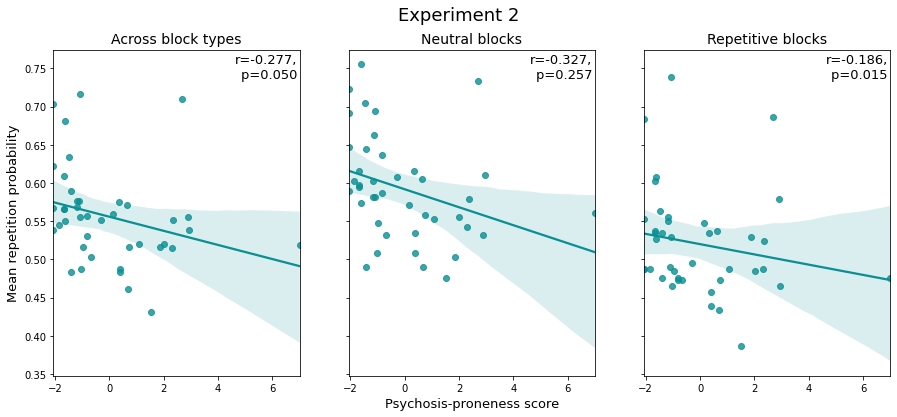

In [17]:
# create some plots next.

fig, axs = plt.subplots(1,3, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

_=plt.suptitle('Experiment 2', fontsize=18)

# plot overall mean repetition probability and PPS
_=axs[0].set_title('Across block types',fontsize=14)
_=sns.regplot(ax=axs[0], x=df_rep['PPS'], y=df_rep['rep_prob'], color='#0A9094')
_=plt.text(0.99, 0.99, ('r=%.3f,\n p=0.050'%pc_allBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[0].transAxes, fontsize=13)
_=axs[0].set_ylabel('Mean repetition probability', fontsize=13)
_=axs[0].set_xlabel(None)

# plot neutral mean repetition probability and PPS
_=axs[1].set_title('Neutral blocks',fontsize=14)
_=plt.text(0.99, 0.99, ('r=%.3f,\n p=0.257'%pc_neutBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[1].transAxes, fontsize=13)
_=sns.regplot(ax=axs[1], x=df_rep['PPS'], y=df_rep['rep_prob_neut'], color='#0A9094')
_=axs[1].set_ylabel(None)
_=axs[1].set_xlabel('Psychosis-proneness score', fontsize=13)

# plot repetitive repetition probability and PPS
_=axs[2].set_title('Repetitive blocks',fontsize=14)
_=plt.text(0.99, 0.99, ('r=%.3f,\n p=0.015'%pc_repBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[2].transAxes, fontsize=13)
_=sns.regplot(ax=axs[2], x=df_rep['PPS'], y=df_rep['rep_prob_rep'], color='#0A9094')
_=axs[2].set_ylabel(None)
_=axs[2].set_xlabel(None)

plt.savefig('C:\\Users\\annae\\Dropbox\\PhD\\aud_vis_paper\\svg_files\\rep_prob_exp2.svg')

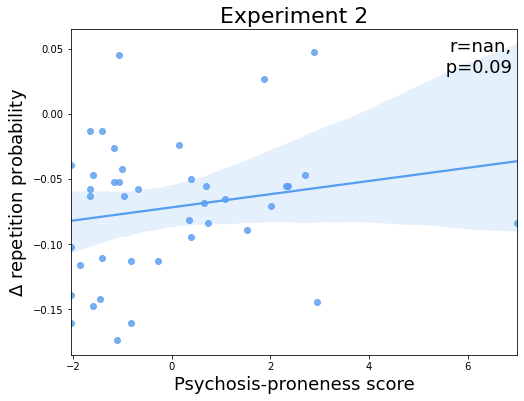

In [18]:
# Create difference plots between blocks and across PPS 
df_rep['rep_prob_diff'] = df_rep['rep_prob_rep'] - df_rep['rep_prob_neut']

corr_pps = np.corrcoef(df_rep['PPS'], df_rep['rep_prob_diff'])
corr_pps = corr_pps[0][1]
corr_pps

pc_diffBlocks = pg.partial_corr(data=df_rep, x='PPS', y='rep_prob_diff')

fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title('Experiment 2', fontsize=22)
_=sns.regplot(ax=ax, x=df_rep['PPS'], y=df_rep['rep_prob_diff'], color='#579DF2')
_=plt.text(-0.87, 0.95, ('r=%.3f,\n p=0.09'%corr_pps), 
           ha='right', va='top', transform=axs[2].transAxes, fontsize=18)
_=ax.set_ylabel(r'$\Delta$ repetition probability', fontsize=18)
_=ax.set_xlabel(r'Psychosis-proneness score', fontsize=18)

plt.savefig('rep_prob_diff_exp2.svg')

## Cue conformity

In [19]:
# make column for cue conformity
df['cue_conf'] = np.nan

for index, row in df.iterrows(): 
    
    if row['response'] == row['cue']: 
        conf = 1
        
    elif row['response'] != row['cue']: 
        conf = 0
        
    df.at[index, 'cue_conf'] = conf
    
df_rep[['cue_conf', 'cue_conf_neut', 'cue_conf_rep']] = np.nan, np.nan, np.nan   
    
for sbj_id in subjects:
    # get overall repetition probability across blocks
    df_sbj = df[df['sbj_id']==sbj_id]
    conf_mean = df_sbj['cue_conf'].mean()
    
    # get repetition probability in repetitive blocks
    conf_rep_mean = df_sbj[df_sbj['block_type']==0]['cue_conf'].mean()
    
    # get repetition probability in neutral blocks
    conf_neut_mean = df_sbj[df_sbj['block_type']==1]['cue_conf'].mean()
    
    # put it in result df
    df_rep.at[sbj_id, 'cue_conf'] = conf_mean
    df_rep.at[sbj_id, 'cue_conf_rep'] = conf_rep_mean
    df_rep.at[sbj_id, 'cue_conf_neut'] = conf_neut_mean
    
df_rep = df_rep.dropna()

In [20]:
df_rep.head()

,rep_prob,rep_prob_rep,rep_prob_neut,PPS,performance,rep_prob_diff,cue_conf,cue_conf_neut,cue_conf_rep
sbj_id,,,,,,,,,
ANE14H,0.609211,0.602632,0.615789,-1.660985,65.526316,-0.013158,0.576316,0.584211,0.568421
ANR14E,0.482895,0.476316,0.489474,-1.415262,66.842105,-0.013158,0.672368,0.692105,0.652632
COR10T,0.551316,0.494737,0.607895,-0.290197,78.289474,-0.113158,0.717105,0.752632,0.681579
DOR31T,0.486842,0.439474,0.534211,0.395197,72.894737,-0.094737,0.603947,0.605263,0.602632
EVR10T,0.589474,0.534211,0.644737,-1.415262,73.684211,-0.110526,0.635526,0.618421,0.652632


In [21]:
# correlate mean cue conformity and PPS in repetitive blocks
corr_pps_cue_rep = np.corrcoef(df_rep['PPS'], df_rep['cue_conf_rep'])
corr_pps_cue_rep = corr_pps_cue_rep[0][1]

# correlate mean repetition prob and PPS in neutral blocks
corr_pps_cue_neut = np.corrcoef(df_rep['PPS'], df_rep['cue_conf_neut'])
corr_pps_cue_neut = corr_pps_cue_neut[0][1]

# correlate overall mean repetition prob and PPS
corr_pps_cue = np.corrcoef(df_rep['PPS'], df_rep['cue_conf'])
corr_pps_cue = corr_pps_cue[0][1]

In [22]:
# partial correlation between PPS and repetition probability but controlled for performance, using pingouin package 
# create partial correlation: general repetition probability 
pc_allBlocks = pg.partial_corr(data=df_rep , x='PPS', y='cue_conf', covar='performance')

# partial corr: repetitive blocks. 
pc_repBlocks = pg.partial_corr(data=df_rep, x='PPS', y='cue_conf_rep', covar='performance')

# partial corr: neutral blocks
pc_neutBlocks = pg.partial_corr(data=df_rep, x='PPS', y='cue_conf_neut', covar='performance')

In [23]:
print('Partial correlation between PPS and conformity with cue, controlled for performance.')
print('Across block types: ')
display(pc_allBlocks)
print('Only repetitive blocks: ')
display(pc_repBlocks)
print('Only neutral blocks: ')
display(pc_neutBlocks)

Partial correlation between PPS and conformity with cue, controlled for performance.
Across block types: 


,n,r,CI95%,p-val
pearson,41,0.170402,"[-0.15, 0.46]",0.29314


Only repetitive blocks: 


,n,r,CI95%,p-val
pearson,41,0.15602,"[-0.16, 0.45]",0.336364


Only neutral blocks: 


,n,r,CI95%,p-val
pearson,41,0.179241,"[-0.14, 0.46]",0.268439


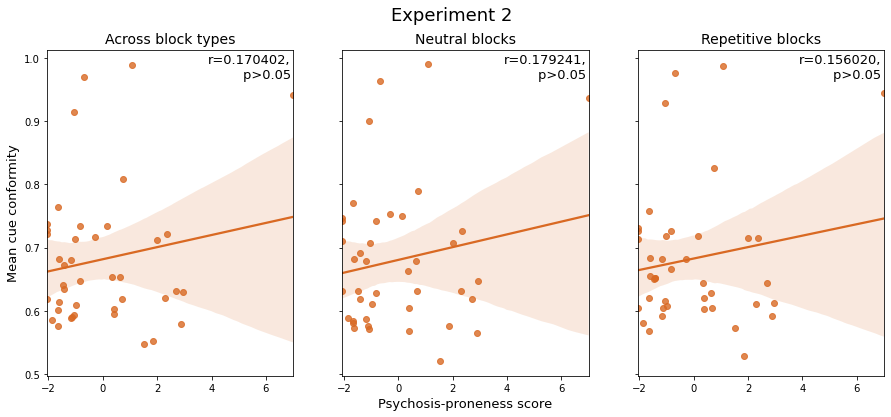

In [24]:
# create some plots on cue conformity next.

fig, axs = plt.subplots(1,3, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

plt.suptitle('Experiment 2', fontsize=18)

# plot overall mean repetition probability and PPS
_=axs[0].set_title('Across block types', fontsize=14)
_=sns.regplot(ax=axs[0], x=df_rep['PPS'], y=df_rep['cue_conf'], color='#D96923')
_=plt.text(0.99, 0.99, ('r=%f,\n p>0.05'%pc_allBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[0].transAxes, fontsize=13)
_=axs[0].set_ylabel('Mean cue conformity', fontsize=13)
_=axs[0].set_xlabel(None)

# plot neutral mean repetition probability and PPS
_=axs[1].set_title('Neutral blocks', fontsize=14)
_=sns.regplot(ax=axs[1], x=df_rep['PPS'], y=df_rep['cue_conf_neut'], color='#D96923')
_=plt.text(0.99, 0.99, ('r=%f,\n p>0.05'%pc_neutBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[1].transAxes, fontsize=13)
_=axs[1].set_xlabel('Psychosis-proneness score', fontsize=13)
_=axs[1].set_ylabel(None)

# plot repetitive repetition probability and PPS
_=axs[2].set_title('Repetitive blocks', fontsize=14)
_=sns.regplot(ax=axs[2], x=df_rep['PPS'], y=df_rep['cue_conf_rep'], color='#D96923')
_=plt.text(0.99, 0.99, ('r=%f,\n p>0.05'%pc_repBlocks['r'].values[0]), 
           ha='right', va='top', transform=axs[2].transAxes, fontsize=13)
_=axs[2].set_xlabel(None)
_=axs[2].set_ylabel(None)

plt.savefig('cue_conf_exp2.svg')